In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
import statsmodels
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import boxcox

In [2]:
df = pd.read_excel('datasets/kuiper.xls')

df.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


In [3]:
#df.Make.value_counts()
#df.Type.value_counts()

In [4]:
df['Make'] = df['Make'].map({'Chevrolet': 1, 'Pontiac': 2, 'SAAB': 3, 'Buick': 4, 'Cadillac': 5, 'Saturn': 6})
df['Type'] = df['Type'].map({'Sedan': 1, 'Coupe': 2, 'Wagon': 3, 'Hatchback': 4, 'Convertible': 5})

df["Model"] = df.groupby('Model')["Price"].transform("mean")
df["Trim"] = df.groupby('Trim')["Price"].transform("mean")

#df = df.drop(['Model', 'Trim'], axis=1)

df.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,4,15989.528107,22084.082849,1,6,3.1,4,1,1,1
1,17542.036083,9135,4,15989.528107,22084.082849,1,6,3.1,4,1,1,0
2,16218.847862,13196,4,15989.528107,22084.082849,1,6,3.1,4,1,1,0
3,16336.913140,16342,4,15989.528107,22084.082849,1,6,3.1,4,1,0,0
4,16339.170324,19832,4,15989.528107,22084.082849,1,6,3.1,4,1,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     804 non-null    float64
 1   Mileage   804 non-null    int64  
 2   Make      804 non-null    int64  
 3   Model     804 non-null    float64
 4   Trim      804 non-null    float64
 5   Type      804 non-null    int64  
 6   Cylinder  804 non-null    int64  
 7   Liter     804 non-null    float64
 8   Doors     804 non-null    int64  
 9   Cruise    804 non-null    int64  
 10  Sound     804 non-null    int64  
 11  Leather   804 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 75.5 KB


## a.	Провести корреляционный анализ имеющихся данных 

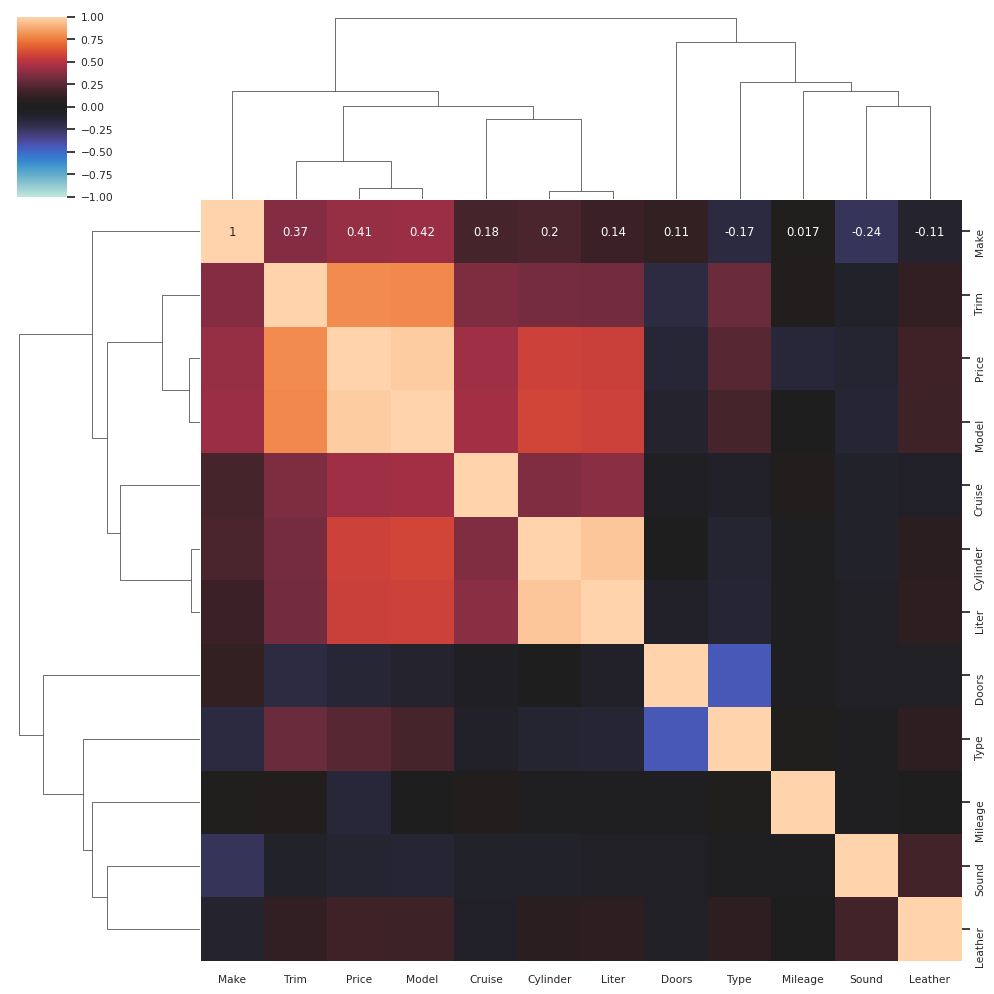

In [6]:
sns.set (font_scale=0.7)
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df)

## b.	Построить базовую модель линейной регрессии.

Предполагается, что Цена может завистеть от остальных показателей.

In [7]:
target = 'Price'
features = list(df.columns)
features.remove(target)

X = df[features]
y = df[[target]]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.reshape(-1), train_size=0.8) # делит на соотношение

reg = LinearRegression()

reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.9722535635937487

## c.	Вывести результаты анализа базовой модели.

In [8]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2236.
Date:                Thu, 07 Dec 2023   Prob (F-statistic):               0.00
Time:                        11:55:41   Log-Likelihood:                -5639.5
No. Observations:                 643   AIC:                         1.130e+04
Df Residuals:                     631   BIC:                         1.136e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1004.4618    547.093      1.836      0.0

##### f. Проверить значимость построенного уравнения регрессии с помощью F-test: 

Prob (F-statistic):               0.00 < 0.05 => Построение уравнения регрессии значимо в целом

Prob(JB): 9.18e-28 < 0.05 => Остатки не нормальные

## g.	Построить график рассеяния и уравнения регрессии.

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

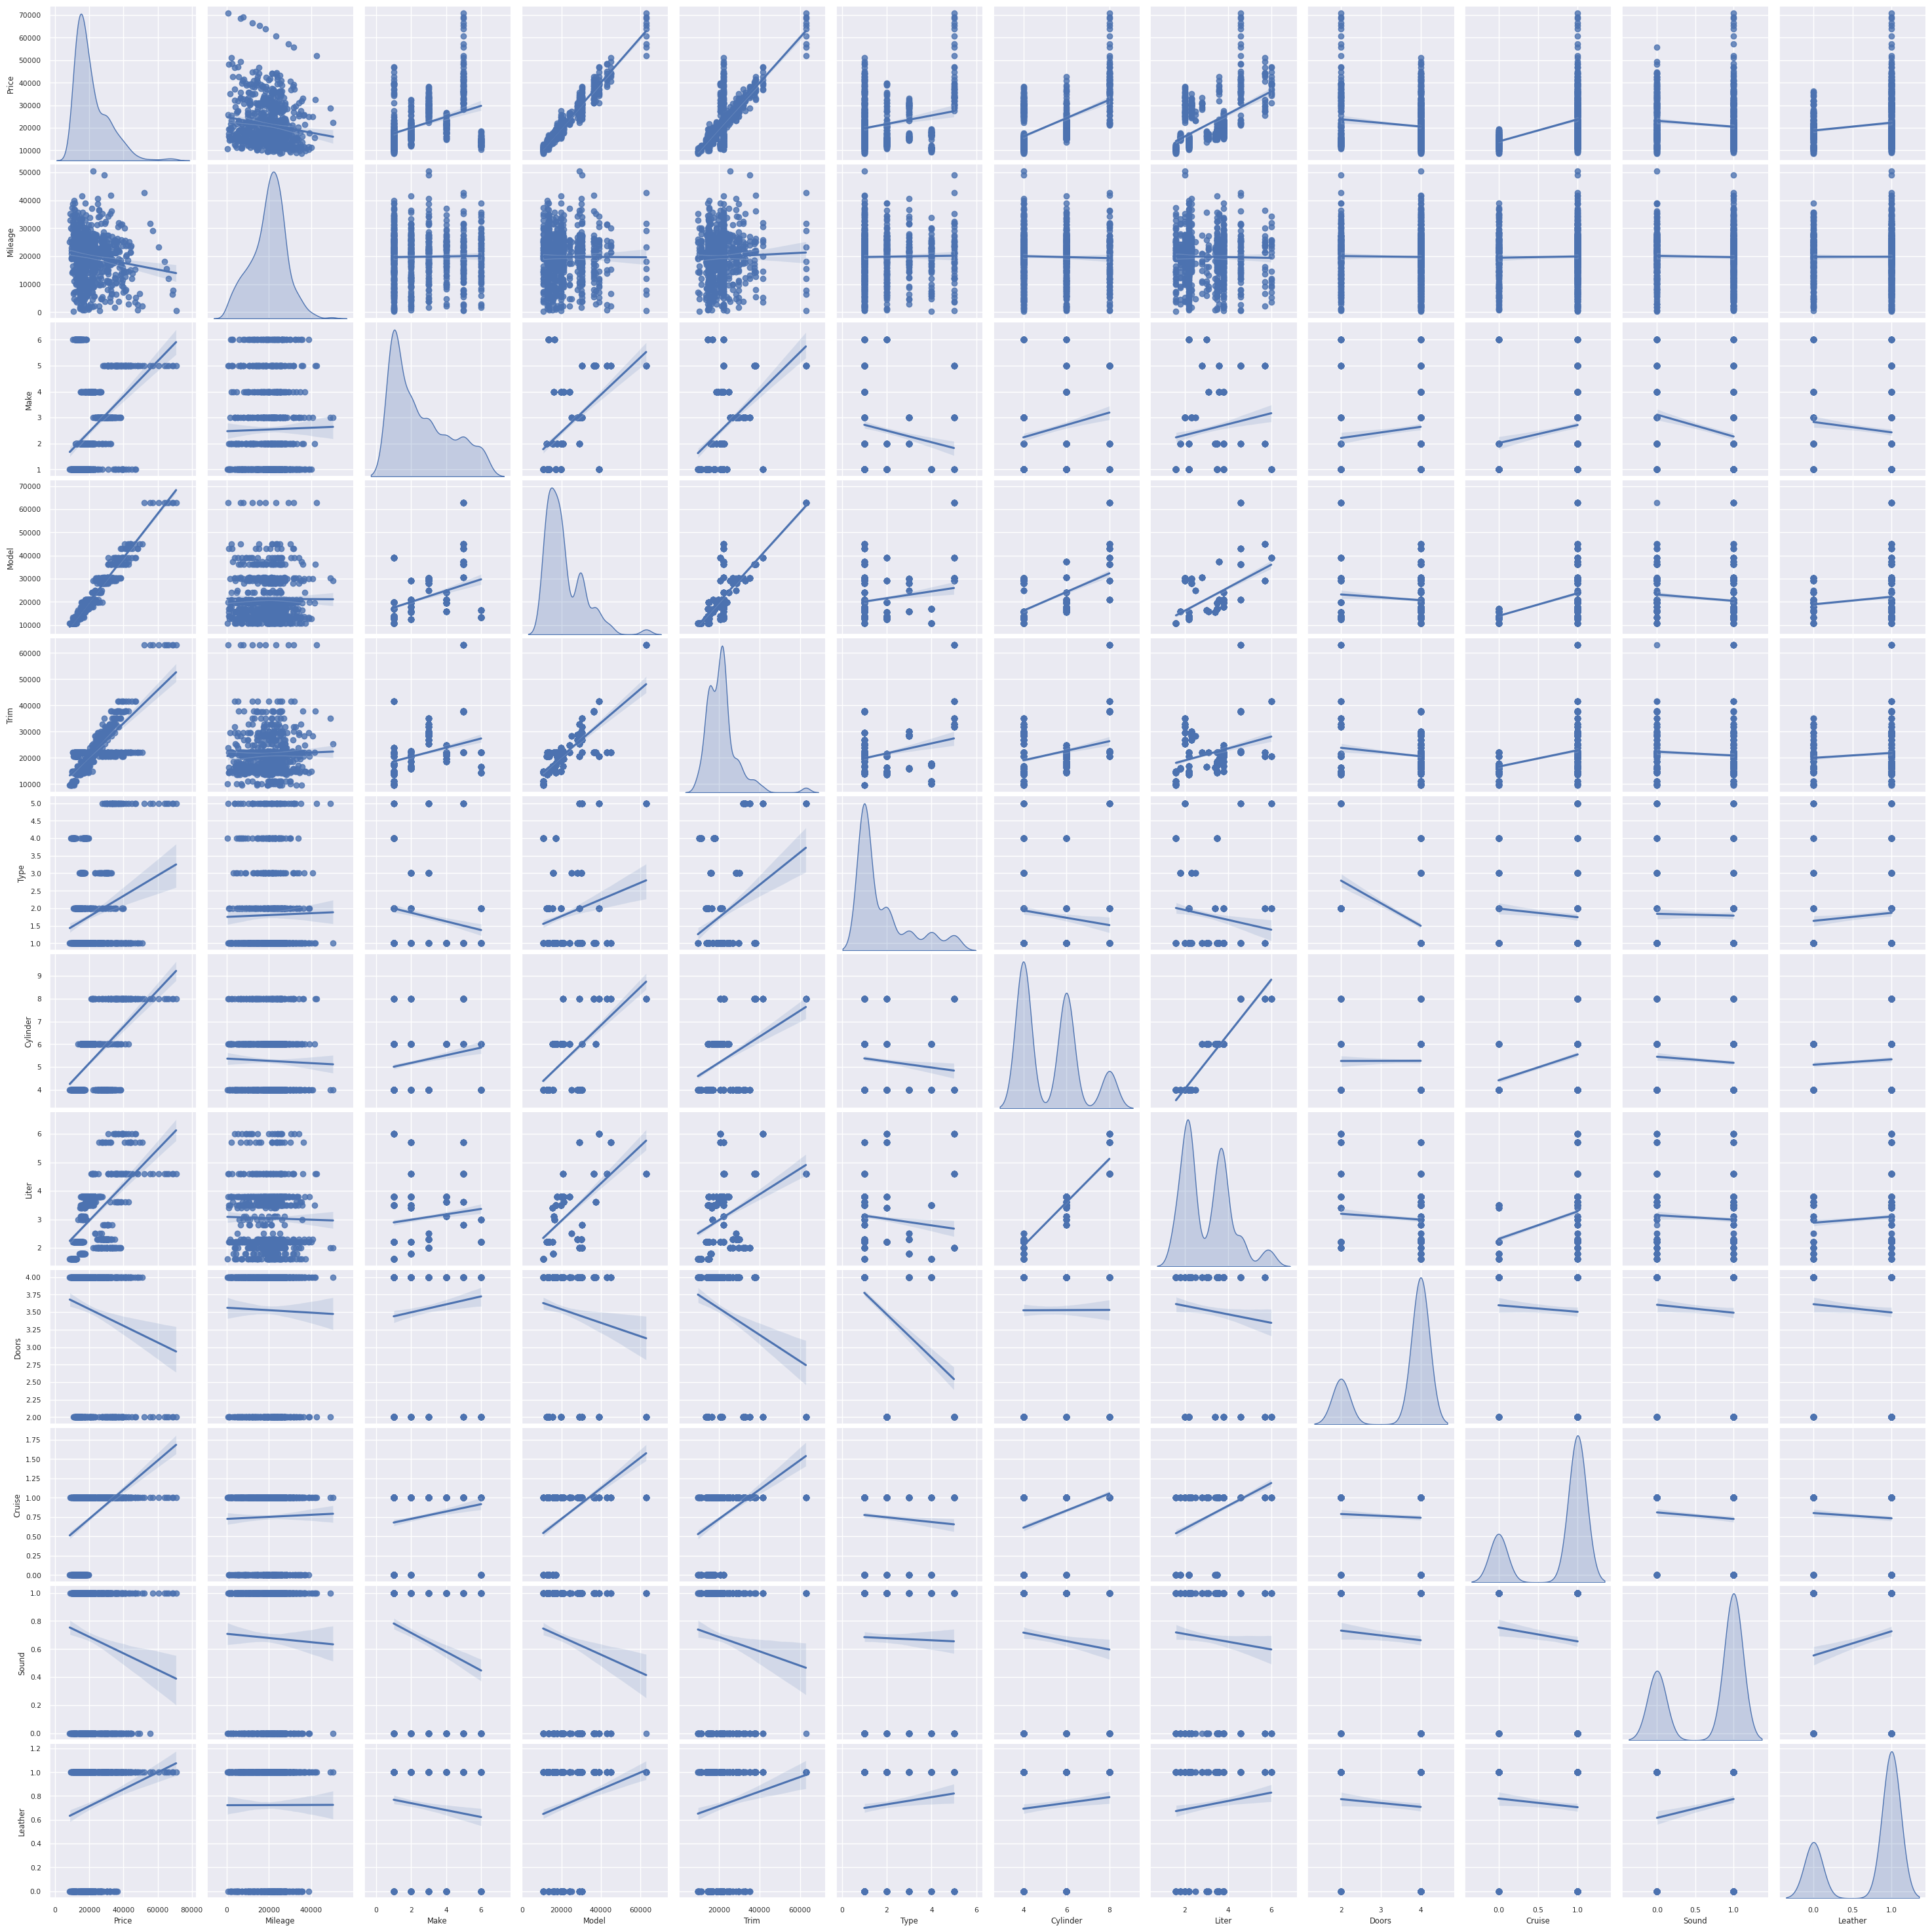

In [9]:
sns.pairplot(df, kind='reg', markers='o', diag_kind='kde', height=2.5);
plt.show();

## i.	В случае подозрения на наличие выбросов, проверить так называемые важные наблюдения, которые значительно влияют на построение модели. 

In [10]:
influence = OLSInfluence(est2)
influence = influence.results.get_influence()
influence.summary_frame()

,dfb_const,dfb_x1,dfb_x2,dfb_x3,dfb_x4,dfb_x5,dfb_x6,dfb_x7,dfb_x8,dfb_x9,dfb_x10,dfb_x11,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.001408,0.004427,0.003627,0.048334,-0.043462,-0.014816,0.029072,-0.031598,-0.008370,-0.005619,-0.014872,0.009065,0.000423,0.385783,0.033008,0.071276,0.385523,0.071228
1,-0.023297,-0.016281,0.012372,0.024472,0.008670,0.046508,-0.064651,0.043365,0.065825,0.031720,0.034717,0.018955,0.001452,1.106975,0.014019,0.131996,1.107173,0.132019
2,-0.002263,-0.003403,0.001499,0.000019,-0.003121,0.005353,0.001346,-0.002267,0.003446,0.006030,0.002534,0.003040,0.000010,0.092618,0.013843,0.010973,0.092545,0.010965
3,0.015812,-0.010358,-0.031367,0.007645,0.010403,-0.005872,-0.023084,0.019219,0.002715,-0.010597,-0.020846,0.014476,0.000238,-0.338958,0.024212,-0.053393,-0.338720,-0.053355
4,0.022302,-0.004688,-0.014698,0.026241,-0.017666,0.001604,-0.033217,0.025797,0.000136,-0.013855,-0.023982,0.026637,0.000351,-0.517819,0.015477,-0.064924,-0.517519,-0.064886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,0.016791,-0.032016,-0.017846,-0.000379,0.008883,-0.005107,0.001372,-0.005296,-0.008998,-0.004852,-0.025001,0.029304,0.000282,-0.489547,0.013916,-0.058156,-0.489252,-0.058121
639,-0.069875,0.083949,0.033507,-0.063259,0.011602,0.060810,0.005451,0.029503,0.002779,-0.019849,0.069799,-0.032858,0.002102,-1.010020,0.024128,-0.158816,-1.010036,-0.158819
640,0.020658,-0.030345,-0.020661,0.004847,0.007724,-0.004626,0.000285,-0.003356,-0.007162,-0.009485,-0.015358,-0.013252,0.000178,-0.408519,0.012636,-0.046214,-0.408249,-0.046184
641,-0.000049,0.003212,-0.002553,0.002205,-0.005621,0.008509,0.001695,-0.003627,0.005719,0.007816,-0.008195,-0.008167,0.000042,0.177983,0.015486,0.022322,0.177846,0.022305


Таблица важности отдельных значений. Звздочек нет- ничго не можем сказать

## j.	Используя функцию Step или StepAIC, постараться улучшить модель. 

In [11]:
def forward_selection(X, y):
    selected_features = []
    remaining_features = set(X.columns)
    best_aic = np.inf

    while remaining_features:
        aic_values = []
        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[selected_features + [feature]])).fit()
            aic = model.aic
            aic_values.append((feature, aic))

        best_feature, best_aic_candidate = min(aic_values, key=lambda x: x[1])

        if best_aic_candidate < best_aic:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_aic = best_aic_candidate
        else:
            break

    return selected_features            
            

In [12]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print("prev AIC: ", est2.aic)

new_features = forward_selection(X, y) # сам выбирает переменные для лучшей модели
new_X = df[new_features]

X2 = sm.add_constant(new_X)
est = sm.OLS(y, X2)
est2 = est.fit()
print("new AIC: ", est2.aic)

prev AIC:  14143.112570938396
new AIC:  14139.615978134927


Берем попеременно фичи и выкидаваем их и смотрим AIC, если оно стало лучше, то убираем фичу из модели

## k.	В случае получения в предыдущем пункте модели, отличной от базовой, повторить пп. c-i для новой модели.

In [13]:
X = df[new_features]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.reshape(-1), train_size=0.8)

reg = LinearRegression()

reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.9734324681021082

In [14]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     3050.
Date:                Thu, 07 Dec 2023   Prob (F-statistic):               0.00
Time:                        11:56:46   Log-Likelihood:                -5646.6
No. Observations:                 643   AIC:                         1.131e+04
Df Residuals:                     634   BIC:                         1.135e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        511.0085    376.427      1.358      0.1

## l.	Построить графики: scatterplot, "Residuals vs Fitted", "Normal Q-Q" , "Residuals vs Leverage" и дать интерпретации. 

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

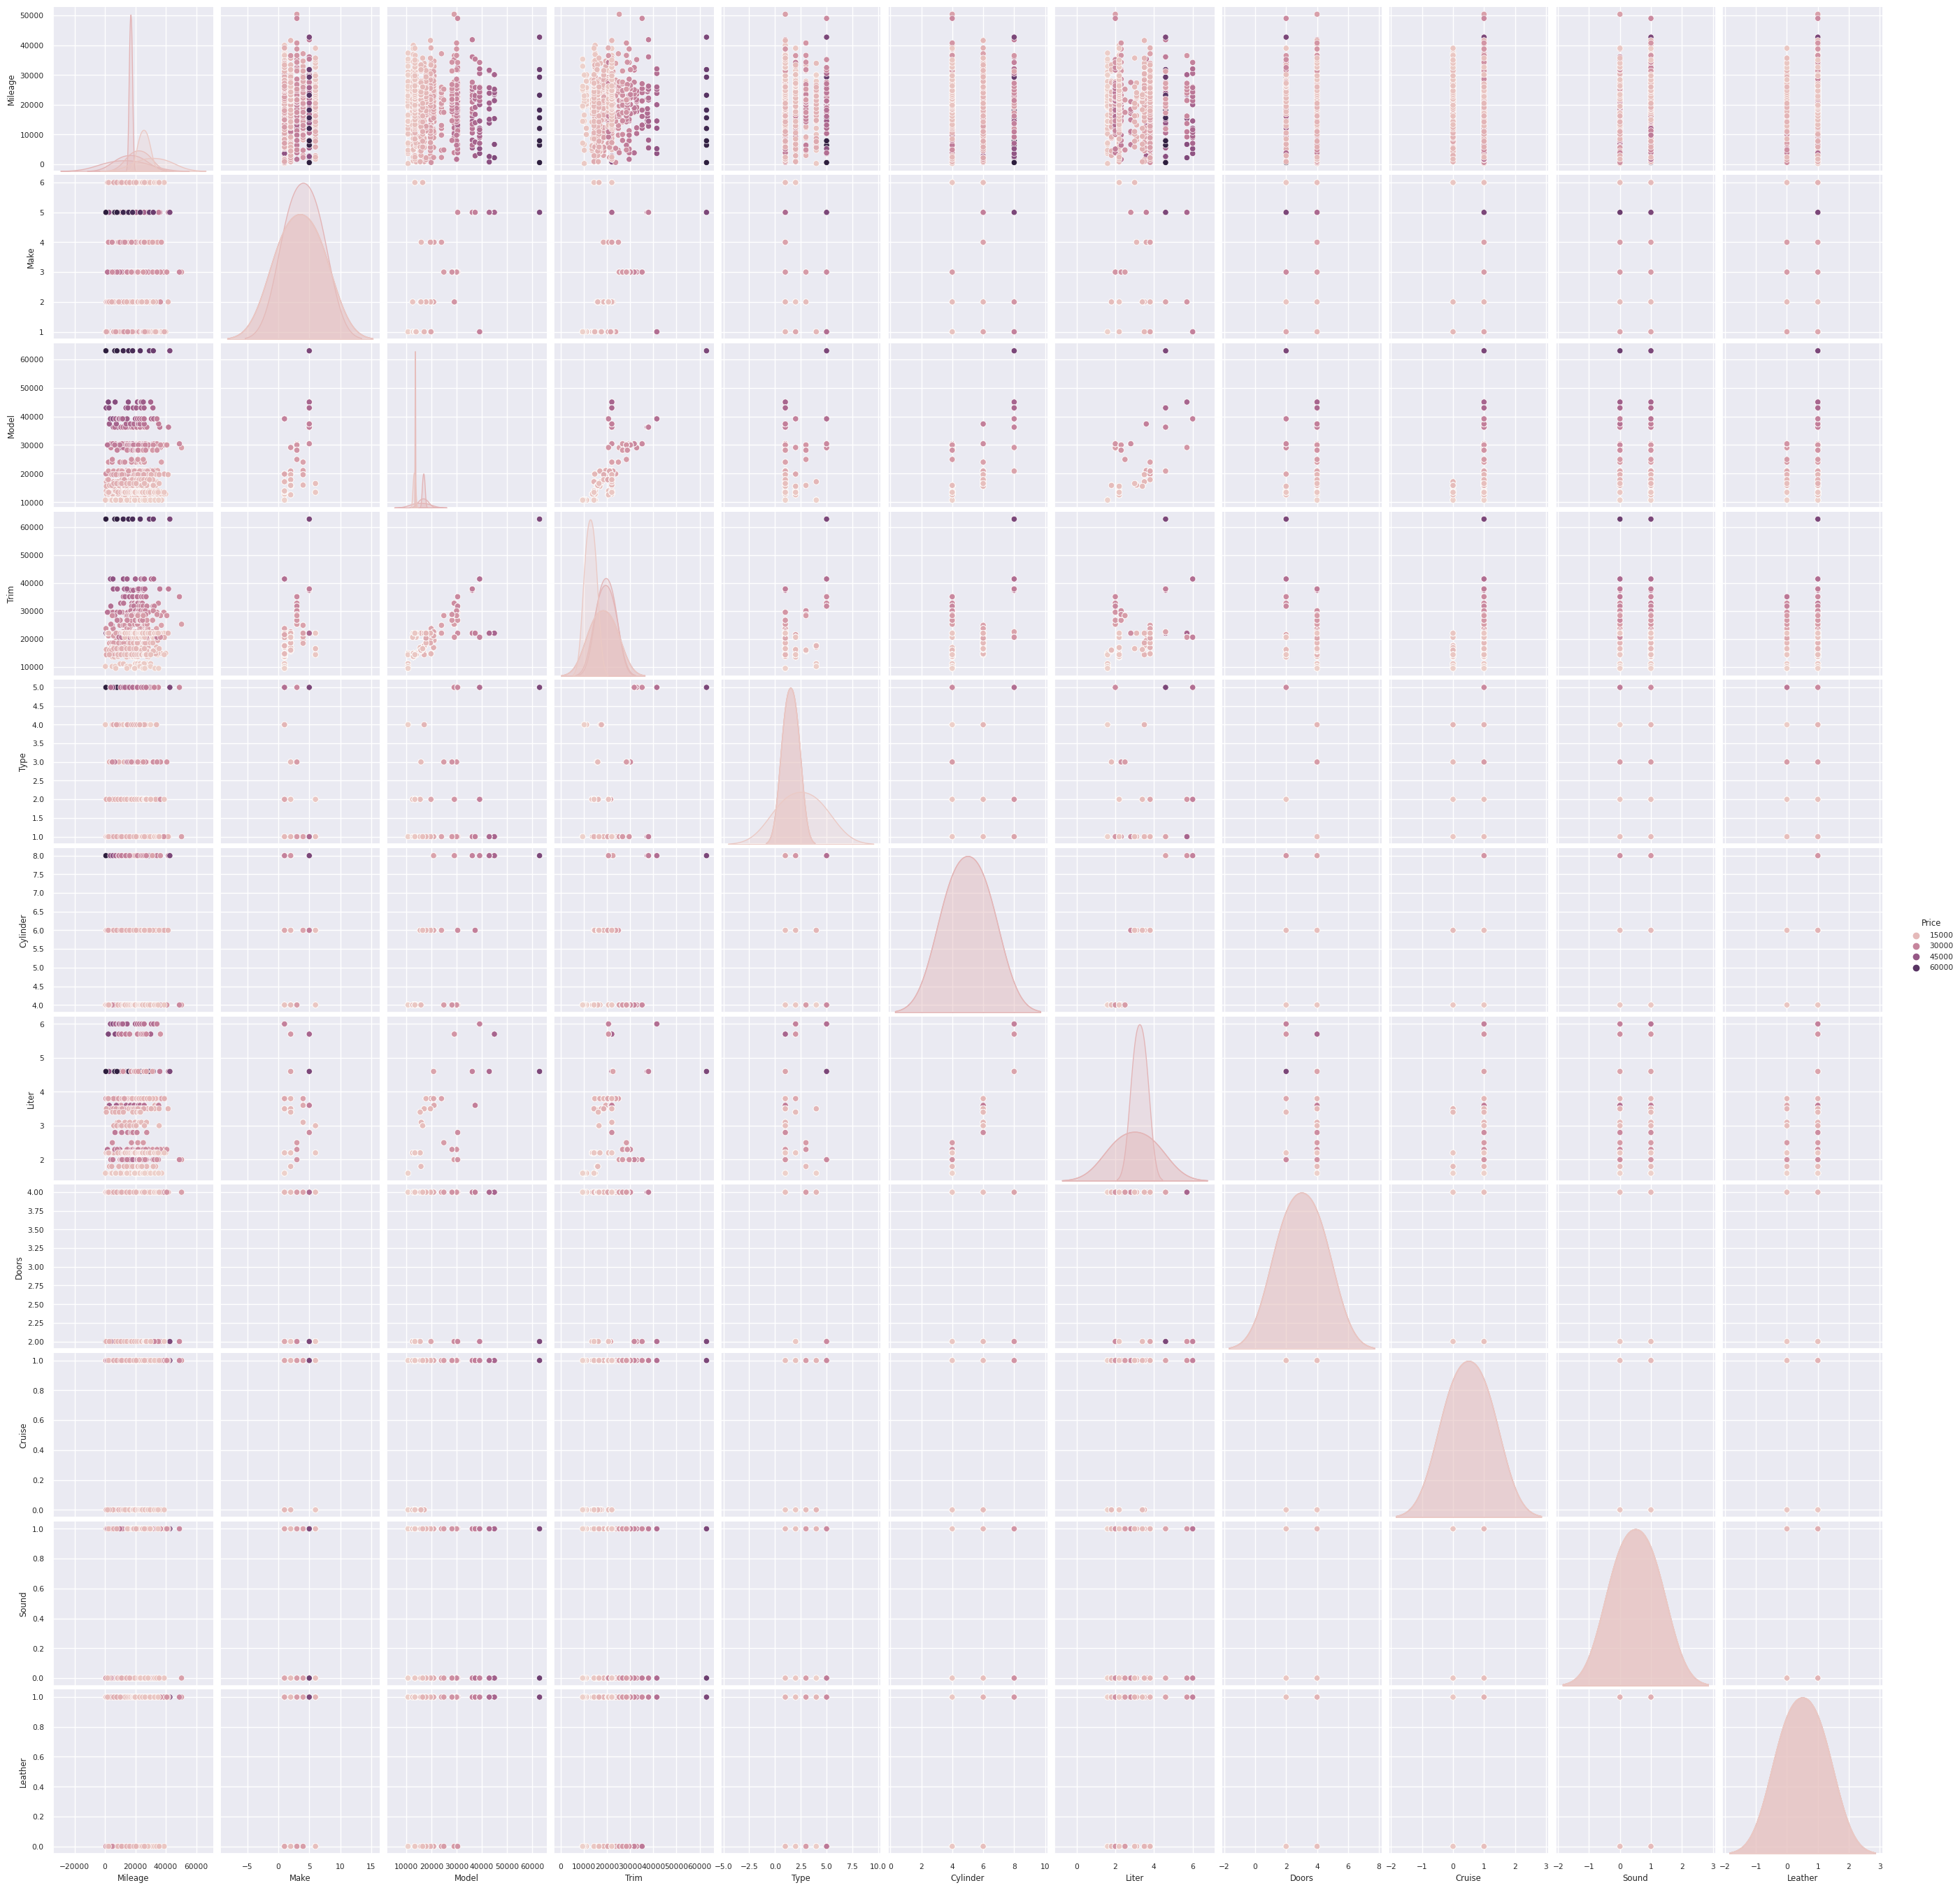

In [15]:
sns.pairplot(df, diag_kind='kde', markers='o', hue='Price');
plt.show();

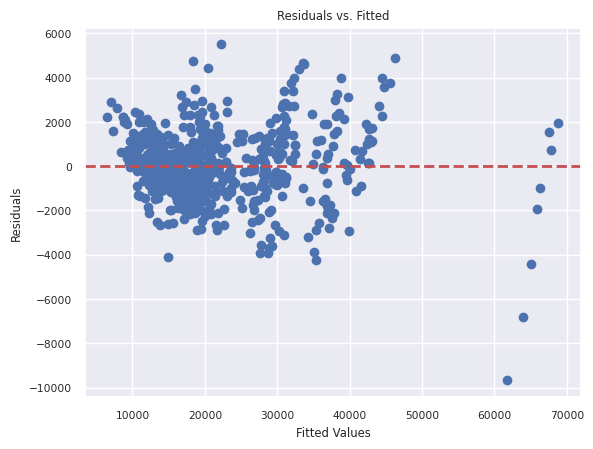

In [16]:
model = sm.OLS(y_train, X_train).fit()

residuals = model.resid
fitted_values = model.fittedvalues

plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residuals vs. Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

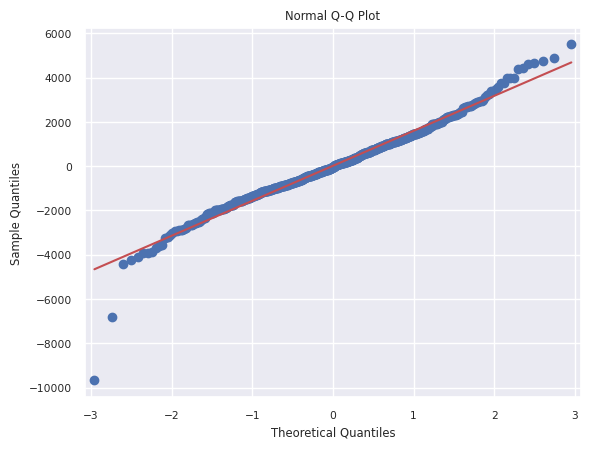

In [17]:
sm.qqplot(residuals, line='s')
plt.title('Normal Q-Q Plot')
plt.show()

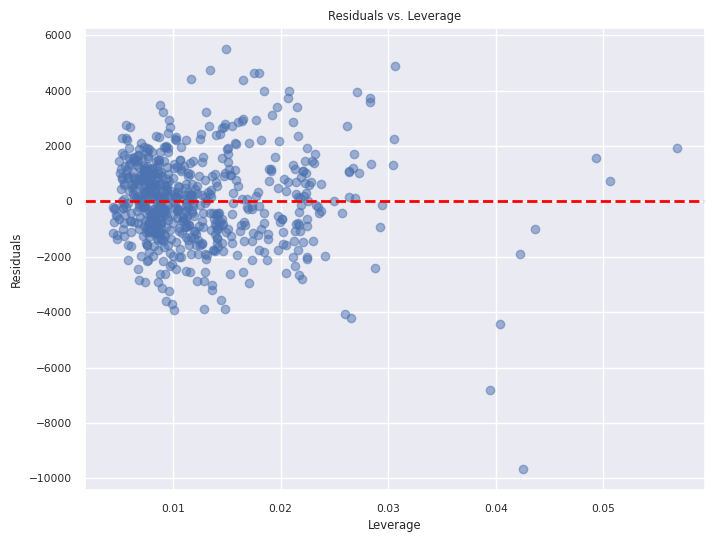

In [18]:
leverage = OLSInfluence(model).hat_matrix_diag

plt.figure(figsize=(8, 6))
plt.scatter(leverage, residuals, alpha=0.5)
plt.title('Residuals vs. Leverage')
plt.xlabel('Leverage')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.show()

Чем дальше от 0, тем вероятнее, что это выброс

## m.	Проверить модель на наличие выбросов. 

In [19]:
model = sm.OLS(y, X).fit()

outlier_test_result = model.outlier_test()

print(outlier_test_result)

     student_resid   unadj_p  bonf(p)
0        -1.020231  0.307929      1.0
1        -0.539619  0.589611      1.0
2        -0.949703  0.342552      1.0
3        -0.543915  0.586653      1.0
4        -0.415040  0.678225      1.0
..             ...       ...      ...
799      -0.592756  0.553513      1.0
800      -0.500712  0.616712      1.0
801      -0.636351  0.524731      1.0
802      -0.445830  0.655841      1.0
803      -0.398538  0.690341      1.0

[804 rows x 3 columns]


Выбрасываем значения не равные 1

## n.	Проверить модель на гетероскедастичность.

Разные дисперсии остатков - гетероскедастичность

Одинаковые остатки - гомоскедастичность

In [20]:
# mod_sm = sm.OLS(y, X)
# res_sm = mod_sm.fit()

# bp_lm, bp_lm_pvalue, bp_fvalue, bp_f_pvalue = sm.stats.diagnostic.het_breuschpagan(res_sm.resid, res_sm.model.exog)

name = ['F statistic', 'p-value']
test = statsmodels.stats.diagnostic.het_goldfeldquandt(model.resid, model.model.exog)
result = dict(zip(name, test))

print(result)

# if bp_lm_pvalue < 0.05:
#     print("Heteroscedasticity detected")
# else:
#     print("No heteroscedasticity detected")
# print("Breusch-Pagan test p-value:", bp_lm_pvalue)

{'F statistic': 0.7176508880401483, 'p-value': 0.9994867481902167}


остатки гомоскедачтиные

## o.	Проверить остатки модели на автокорреляцию.

- это связано с тем, что изменение один коэффицент можно выразить через линейную комбинацию других коэф.

Durbin-Watson:                   1.935

## p.	Проверить остатки модели на нормальность распределения. 

остаки не нормально распр

## q.	Проверить модель на мультиколлинеарность данных.

In [21]:
def calculate_vif(data_frame):
    variables = data_frame.columns
    vif_data = pd.DataFrame()
    vif_data["Variable"] = variables
    vif_data["VIF"] = [sm.OLS(data_frame[variable],
                              sm.add_constant(data_frame.loc[:, data_frame.columns != variable])).fit().rsquared
                      for variable in variables]
    return vif_data

vif_results = calculate_vif(df[new_features])
print(vif_results)

   Variable       VIF
0     Model  0.771422
1   Mileage  0.005860
2      Type  0.253981
3      Trim  0.665296
4  Cylinder  0.430224
5      Make  0.292584
6    Cruise  0.254679
7   Leather  0.083639


Если < 5 => переменные не коррелируют

## r.	Попробовать применить трансформацию Box-Cox зависимой переменной.

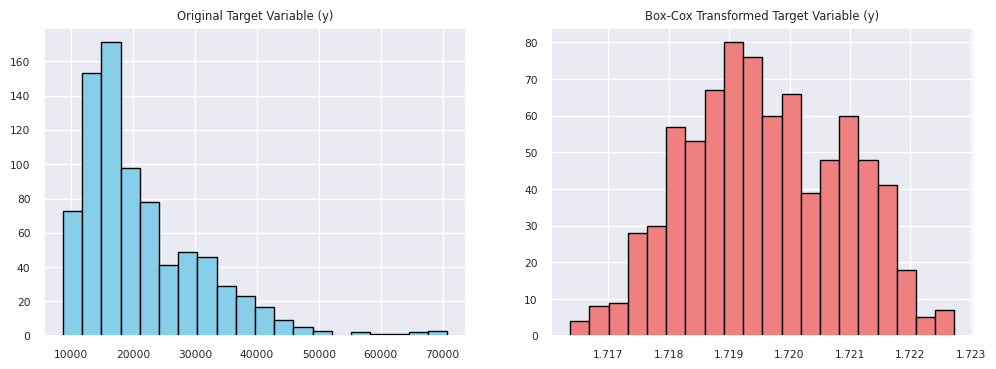

Optimal lambda for transformation of target variable y: -0.5795770407842654


In [22]:
y = df['Price']
transformed_y, lambda_y = boxcox(y + 1e-6) 
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y, bins=20, edgecolor='black', color='skyblue')
plt.title('Original Target Variable (y)')

plt.subplot(1, 2, 2)
plt.hist(transformed_y, bins=20, edgecolor='black', color='lightcoral')
plt.title('Box-Cox Transformed Target Variable (y)')

plt.show()

print(f'Optimal lambda for transformation of target variable y: {lambda_y}')

Предсказывать у в данной степени, мы можем улучшить модель

## s.	В случае получения новой модели в предыдущем пункте проанализировать новую модель.

In [23]:
X = df[new_features]

X_train, X_test, y_train, y_test = train_test_split(X.values, transformed_y.reshape(-1), train_size=0.8)

reg = LinearRegression()

reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.862137362105088

In [28]:
X2 = sm.add_constant(X)
est = sm.OLS(transformed_y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     624.4
Date:                Thu, 07 Dec 2023   Prob (F-statistic):               0.00
Time:                        11:59:32   Log-Likelihood:                 5002.4
No. Observations:                 804   AIC:                            -9987.
Df Residuals:                     795   BIC:                            -9945.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7170      0.000   1.71e+04      0.0

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

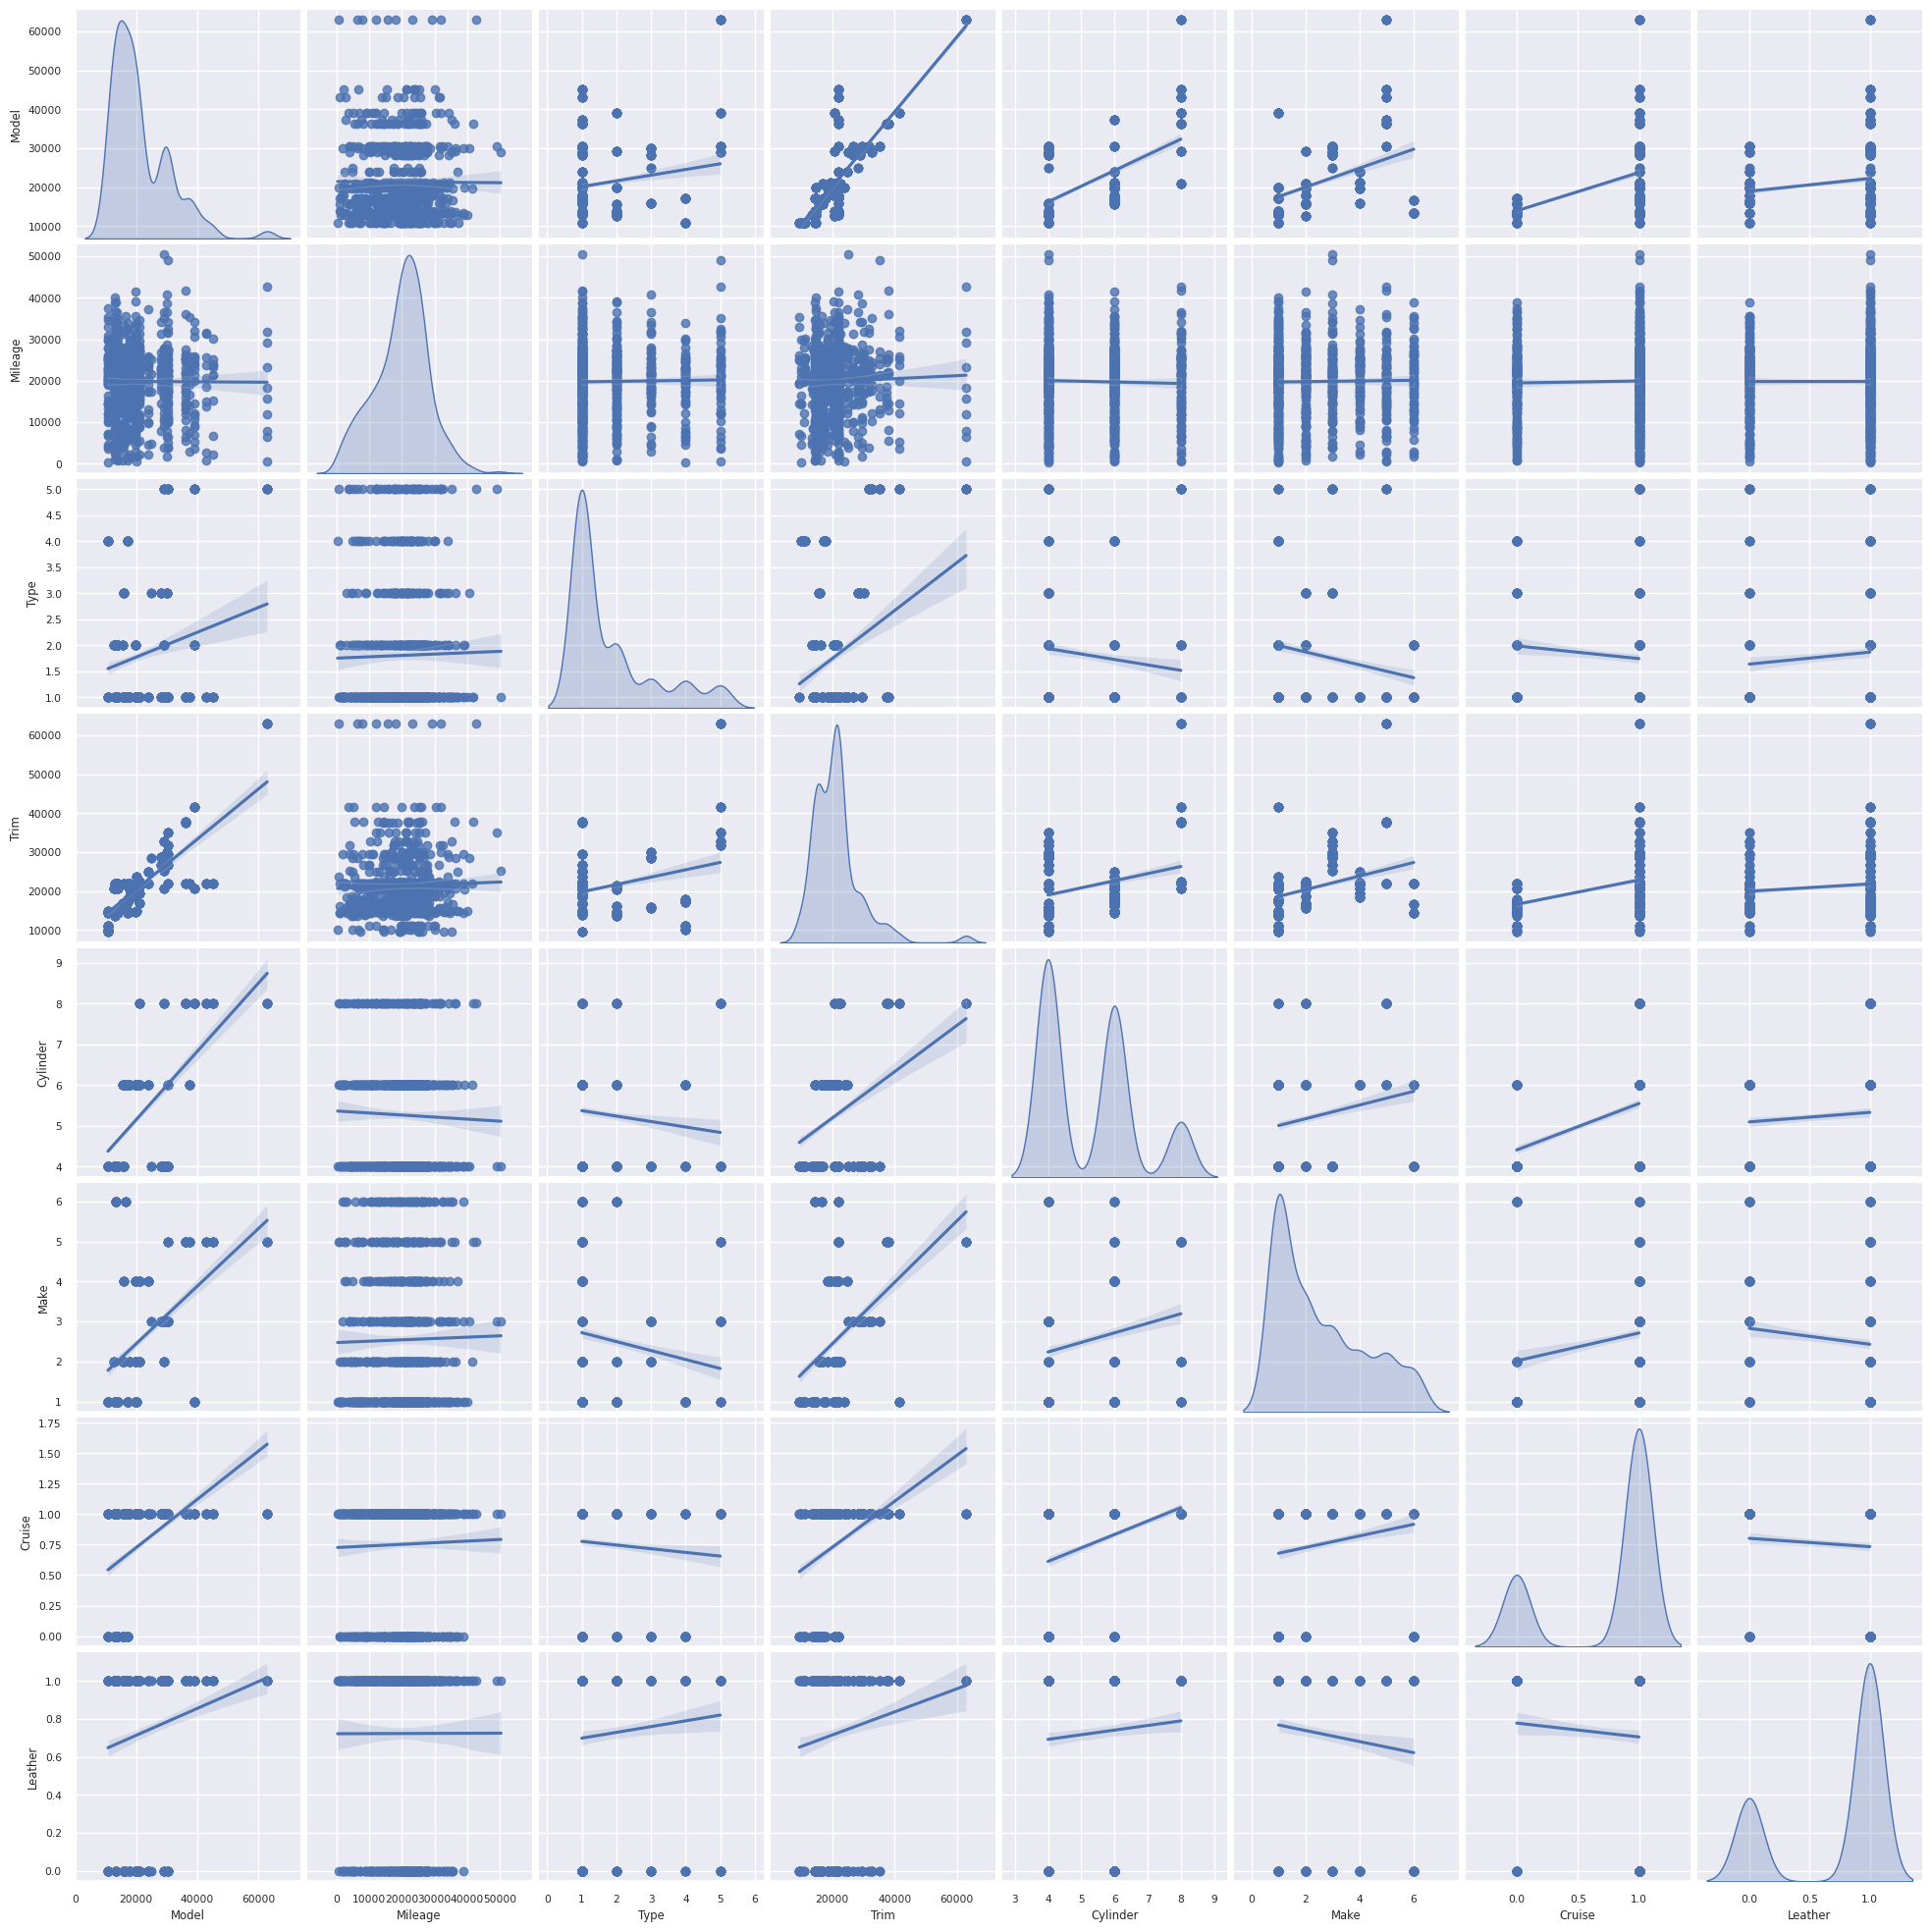

In [ ]:
sns.pairplot(df[new_features], kind='reg', markers='o', diag_kind='kde', height=2.5)
plt.show();

In [ ]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print("prev AIC: ", est2.aic)

new_features = forward_selection(X, y)
new_X = df[new_features]

X2 = sm.add_constant(new_X)
est = sm.OLS(y, X2)
est2 = est.fit()
print("new AIC: ", est2.aic)

prev AIC:  14139.615978134927
new AIC:  14139.615978134927


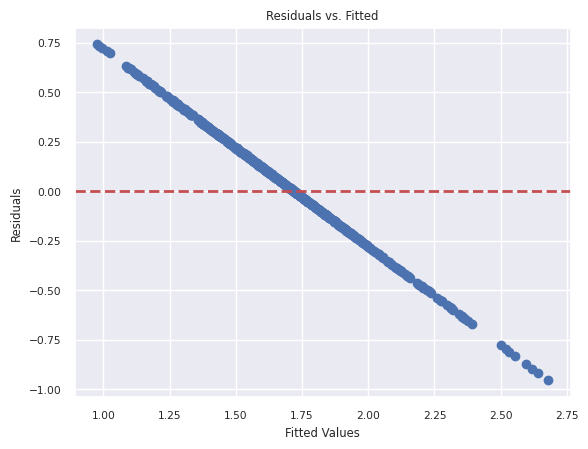

In [ ]:
model = sm.OLS(y_train, X_train).fit()

residuals = model.resid
fitted_values = model.fittedvalues

plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residuals vs. Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

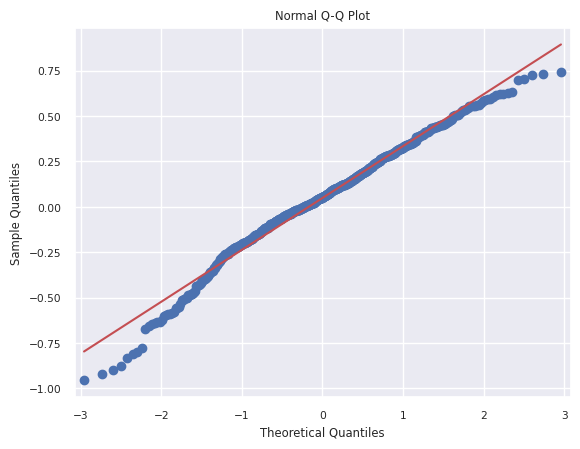

In [ ]:
sm.qqplot(residuals, line='s')
plt.title('Normal Q-Q Plot')
plt.show()

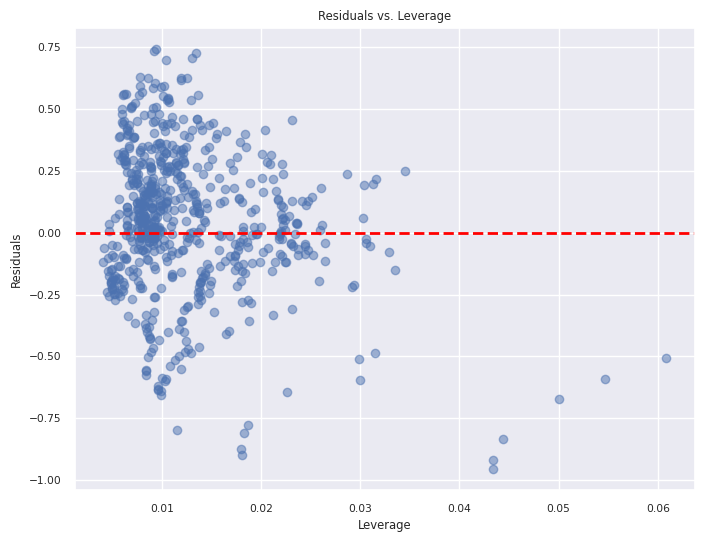

In [ ]:
leverage = OLSInfluence(model).hat_matrix_diag

plt.figure(figsize=(8, 6))
plt.scatter(leverage, residuals, alpha=0.5)
plt.title('Residuals vs. Leverage')
plt.xlabel('Leverage')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.show()

In [ ]:
model = sm.OLS(y, X).fit()

outlier_test_result = model.outlier_test()

print(outlier_test_result)

     student_resid   unadj_p  bonf(p)
0        -1.020231  0.307929      1.0
1        -0.539619  0.589611      1.0
2        -0.949703  0.342552      1.0
3        -0.543915  0.586653      1.0
4        -0.415040  0.678225      1.0
..             ...       ...      ...
799      -0.592756  0.553513      1.0
800      -0.500712  0.616712      1.0
801      -0.636351  0.524731      1.0
802      -0.445830  0.655841      1.0
803      -0.398538  0.690341      1.0

[804 rows x 3 columns]


In [ ]:
a, p_value, b, c = het_breuschpagan(model.resid, X2)

if p_value < 0.05:
    result = 'дисперсии остатков различны'
else:
    result = 'дисперсии остатков одинаковы'
print("Breusch-Pagan test p-value:", p_value)
print(result)

Breusch-Pagan test p-value: 5.852814589642431e-25
дисперсии остатков различны


In [ ]:
durbin_watson_statistic = durbin_watson(residuals)

if durbin_watson_statistic < 2:
    result = 'negative autocorrelation'
else:
    result = 'negative autocorrelation'
print(f'Durbin-Watson test: {result:>21s}')
print(durbin_watson_statistic)

Durbin-Watson test: negative autocorrelation
1.8823701097136738


In [ ]:
jarque_bera_stat, p_value, skewness, kurtosis = sm.stats.jarque_bera(residuals)

if p_value < 0.05:
    result = 'normal distribution'
else:
    result = 'NOT normal distribution'
print(f'Jarque-Bera test: {result:>21s}')
print(p_value)

Jarque-Bera test:   normal distribution
1.5307761272392643e-07


In [ ]:
def calculate_vif(data_frame):
    variables = data_frame.columns
    vif_data = pd.DataFrame()
    vif_data["Variable"] = variables
    vif_data["VIF"] = [sm.OLS(data_frame[variable],
                              sm.add_constant(data_frame.loc[:, data_frame.columns != variable])).fit().rsquared
                      for variable in variables]
    return vif_data

vif_results = calculate_vif(df[new_features])
print(vif_results)

   Variable       VIF
0     Model  0.771422
1   Mileage  0.005860
2      Type  0.253981
3      Trim  0.665296
4  Cylinder  0.430224
5      Make  0.292584
6    Cruise  0.254679
7   Leather  0.083639
